# <center> Проект. Задача классификации.

In [190]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

#Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Импортируем библиотеку предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')

#Импортируем все необходимые библиотеки для ML
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Постановка задачи

### Бизнес задача:
Определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счет этого повысить результативность маркетиноговой компании.

### Техническая задача как для специалиста в Data Science:
Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## 2. Знакомство с данными, обработка пропусков и выбросов

Данные представлены в обучающем модуле Skillfactory. Загружены в папку data.

* bank_fin.csv

## Знакомство с данными

In [191]:
#Загружаем датафрейм
df = pd.read_csv('data/bank_fin.csv', sep = ';')

***Данные о клиентах:***

* _age_ - возраст
* _job_ - сфера занятости
* _marital_ - семейное положение
* _education_ - уровень образования
* _default_ - имеется ли просроченный кредит
* _housing_ - имеется ли кредит на жилье
* _loan_ - имеется ли кредит на личные нужды
* _balance_ - баланс

***Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:***

* _contact_ - тип контакта с клиентом
* _month_ - месяц, в котором был последний контакт
* _day_ - день, в который был последний контакт
* _duration_ - продолжительность контакта в секундах

***Прочие признаки:***

* _campaign_ - количество контактов с этим клиентом в течение текущей кампании
* _pdays_ - количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей
* _previous_ - количество контактов до текущей кампании
* _poutcome_ - результат прошлой маркетинговой кампании

***Целевая переменная***

* _deposit_ - определяет, согласится ли клиент открыть депозит в банке

In [192]:
#Смотрим на датафрейм и выводим информацию
display(df.head(5))
df.info()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2.1

In [193]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

display(df.isnull().sum())

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Данные пропущены в признаке balance. Всего имеется 25 пропусков.

### Задание 2.2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
display(df['job'].value_counts)

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 2.3

In [195]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

#Обработка данных
df['balance'] = df['balance'].str.replace('$','')
df['balance'] = df['balance'].str.replace(',','.')
df['balance'] = df['balance'].str.replace(' ','')

#Изменение типа данных
df['balance'] = df['balance'].astype(float)

print('Среднее значение по преобразованному в корректный вид признаку balance: {:.3f}'.format(df['balance'].mean()))



Среднее значение по преобразованному в корректный вид признаку balance: 1529.129


### Задание 2.4

In [196]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее значение по преобразованному в корректный вид признаку balance после заполнения пропусков: {:.3f}'.format(df['balance'].mean()))

Среднее значение по преобразованному в корректный вид признаку balance после заполнения пропусков: 1526.936


### Задание 2.5

In [236]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

#Поиск модальных значений
mode_job = df['job'].mode()[0]
mode_education = df['education'].mode()[0]

#Обработка пропусков с заменой на модальные занчения
df['job'] = df['job'].replace('unknown', mode_job)
df['education'] = df['education'].replace('unknown', mode_education)

#Определение среднего баланса клиентов с самой популярной работой и
#самым популярным уровнем образования
mask = (df['job'] == mode_job) & (df['education'] == mode_education)
mean_balance = round(df[mask]['balance'].mean(), 3)
print(f'Средний баланс для клиентов с самой популярной работой и урвонем образования: {mean_balance}')
    

Средний баланс для клиентов с самой популярной работой и урвонем образования: 1598.883


### Задание 2.6 и 2.7

In [246]:
# удалите все выбросы для признака balance
# ваш код

#Напишем функцию для поиска выбросов методом межквартильного размаха
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, df_cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число очищенных записей: {df_cleaned.shape[0]}')
print(f'Нижняя граница: {round(lower_bound)}')
print(f'Верхняя граница: {round(upper_bound)}')


Число выбросов по методу Тьюки: 1057
Результирующее число очищенных записей: 10105
Нижняя граница: -2241
Верхняя граница: 4063


## 3. Разведывательный анализ данных

В данной части проекта необходимо:

* исследовать данные;
* попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;
* дополнить анализ визуализациями, иллюстрирующими исследование. 

### Задание 3.1

deposit
yes    4681
no     5424
Name: count, dtype: int64

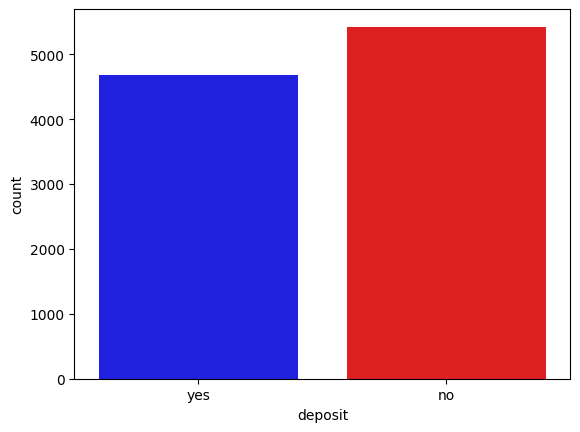

In [256]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

#Определяем количество клиентов открывших и не открывших депозит
display(df_cleaned['deposit'].value_counts(ascending=True))
#Строим 
sns.countplot(data=df_cleaned, x='deposit', palette={'r','b'});

### Задания 3.2 и 3.3

In [261]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

#Задание 3.2 
#Каков максимальный возраст клиента банка?

print('Максимальный возраст клиента банка: {:.0f}'.format(df_cleaned['age'].max()))

#Задание 3.3
#Какова минимальная продолжительность разговора с клиентом банка?
print('Минимальная продолжительность разговора с клиентом банка: {:.0f} секунды'.format(df_cleaned['duration'].min()))


Максимальный возраст клиента банка: 95
Минимальная продолжительность разговора с клиентом банка: 2 секунды


### Задания 4 и 5

In [201]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [202]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [203]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [204]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [205]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [206]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [207]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [208]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [209]:
# преобразуйте уровни образования

### Задания 2 и 3

In [210]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [211]:
# создайте дамми-переменные

### Задания 5 и 6

In [212]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [213]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [214]:
# рассчитайте необходимые показатели

### Задание 9

In [215]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [216]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [217]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [218]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [219]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [220]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [221]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [222]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [223]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [224]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna